In [1]:
import os

In [2]:
os.chdir("wb_transfer-learning/src")

In [3]:
from models.mutual_model import MutualModel
from options.train_options import TrainOptions
from options.test_options import TestOptions
from data.heart_mutual_dataset import HeartMutualDataset
from data.heart_mutual_valid_dataset import HeartMutualValidDataset
from losses.DiceLoss import DiceLoss
from visualizer.visualizer import Visualizer
from utils import plot_image_and_masks

import torch

In [4]:
opt = TestOptions()

In [5]:
opt.gpu_ids = [0]
opt.isTrain = False
opt.checkpoints_dir = "../best_models/128"
opt.name = "mutual"
opt.preprocess = None
opt.input_nc = 1
opt.output_nc = 8
opt.ngf = 64
opt.netG = "resnet_6blocks"
opt.norm = "instance"
opt.no_dropout = True
opt.init_type = "normal"
opt.init_gain = 0.02
opt.load_size = 128
opt.batch_size = 1
opt.serial_batches = False
opt.num_threads = 12


In [6]:
model = MutualModel(opt)
dataset = HeartMutualValidDataset(opt)
valid_dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=opt.batch_size,
        shuffle=not opt.serial_batches,
        num_workers=int(opt.num_threads))


initialize network with normal


In [7]:
model.load_networks("latest")

loading the model from ../best_models/128/mutual/latest_net_S_real.pth
loading the model from ../best_models/128/mutual/latest_net_S_syn.pth


In [8]:
X = dataset[50]
X["T_scan"], X["T_labels"] = X["T_scan"].unsqueeze(0), X["T_labels"].unsqueeze(0)
model.set_input(X)
y = model.forward_return()

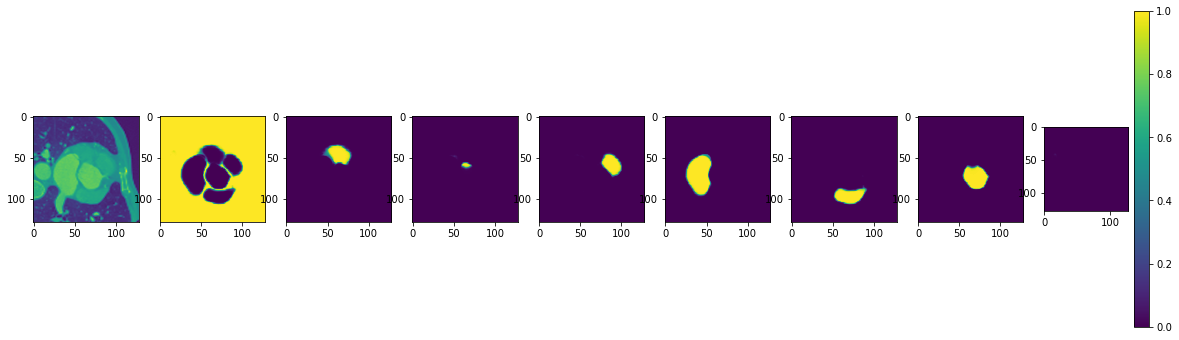

In [9]:
plot_image_and_masks(X["T_scan"].cpu(), y)

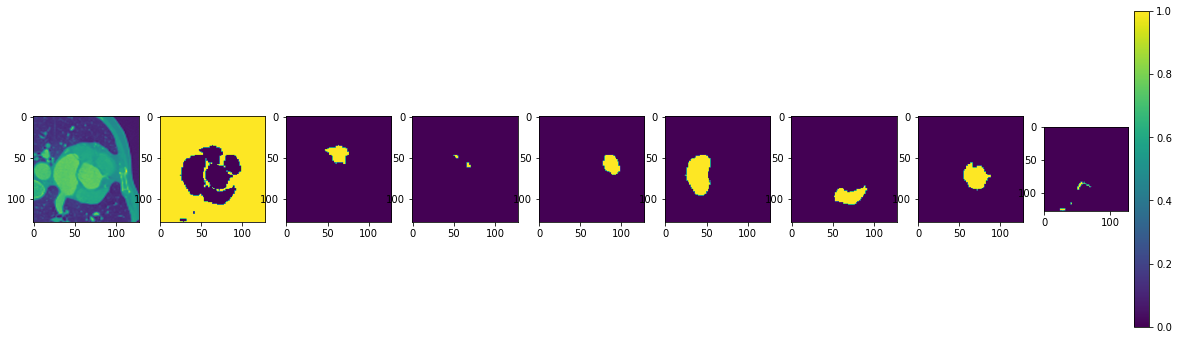

In [10]:
plot_image_and_masks(X["T_scan"].cpu(), X["T_labels"])

In [11]:
def dice_loss(X, y):
    smooth = 1
    max_idx = torch.argmax(X, 1, keepdim=True)
    X.zero_()
    X.scatter_(1, max_idx, 1)
    intersection = (X * y).sum(dim=(2,3))
    dice = (2.*intersection + smooth)/(X.sum(dim=(2,3)) + y.sum(dim=(2,3)) + smooth)
    return dice

In [12]:
dice_loss(y, X["T_labels"])

tensor([[0.9837, 0.8718, 0.4271, 0.9152, 0.9622, 0.9413, 0.9442, 0.0104]])

In [13]:
score = torch.zeros((1, 8))
for data in valid_dataloader:
    model.set_input(data)
    y_hat = model.forward_return()
    y = data["T_labels"]
    score += dice_loss(y, y_hat).sum(dim=0)
score /= len(dataset)

In [18]:
score

tensor([[0.9908, 0.8746, 0.9227, 0.8513, 0.9215, 0.8573, 0.9406, 0.8239]])

In [22]:
score[0,1:].mean()

tensor(0.8846)

In [23]:
score.mean()

tensor(0.8979)